<a href="https://colab.research.google.com/github/kkrphm/project-Models/blob/main/proposed%20Model%20-%20I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [ ]:
# For Data Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils  import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,roc_auc_score, classification_report,roc_curve, auc
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array,ImageDataGenerator, load_img
from keras.utils import np_utils
from tensorflow.keras.utils  import to_categorical
from numpy import expand_dims
from sklearn.preprocessing import LabelBinarizer

# For DL Models
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,LayerNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model,load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.applications import *

# For Data Visualization
import seaborn as sns
import cv2
import plotly.graph_objs as go
from plotly import tools
%matplotlib inline
import matplotlib.pyplot as plt #used for plotting and analyzing data
import matplotlib
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'axes.linewidth':'1',
              'axes.edgecolor':'0',
              'figure.dpi': 600
               }

# Miscellaneous       
import random
import warnings
warnings.filterwarnings("ignore")
import os #file I/O

## **Training & Validation Datasets**

In [ ]:
train_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Training' #data is already in colab file
validation_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
test_data_dir='/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
nb_train_samples =5722
nb_validation_samples =1311
nb_test_samples =153
epochs = 15
batch_size = 64
num_classes=4
seed=123
# input image dimensions
img_rows, img_cols = 512,512
input_shape = (img_rows, img_cols, 3)
IMG_HEIGHT = 512
IMG_WIDTH = 512

# **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")

dev_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size,
  class_mode='sparse')

validation_generator = dev_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(IMG_HEIGHT , IMG_WIDTH),
  batch_size=batch_size,
  class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(IMG_HEIGHT , IMG_WIDTH),
  batch_size=batch_size,
  class_mode='sparse',
  shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Data Visualization**

In [ ]:
index = ['glioma','meningioma','notumor','pituitary']
trained_classes=[]
for i in train_generator.classes:
  trained_classes.append(index[i])
print(trained_classes[:5])
test_classes=[]
for i in test_generator.classes:
  test_classes.append(index[i])
print(test_classes[:5])

['glioma', 'glioma', 'glioma', 'glioma', 'glioma']
['glioma', 'glioma', 'glioma', 'glioma', 'glioma']


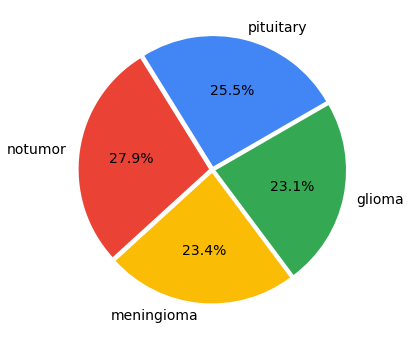

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in trained_classes if x=='pituitary']),
         len([x for x in trained_classes if x=='notumor']),
         len([x for x in trained_classes if x=='meningioma']),
         len([x for x in trained_classes if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

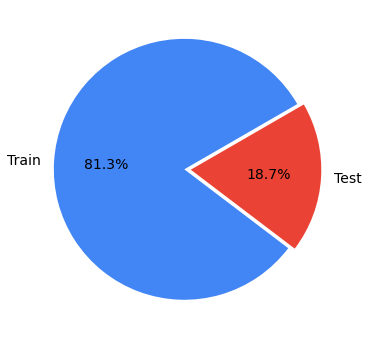

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(trained_classes), len(test_classes)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# **Model Architecture**

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=128,kernel_size=(6,6),strides=(4,4),padding='valid',activation='relu'))
model.add(BatchNormalization(axis=-1))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))


model.add(keras.layers.Conv2D(filters=96,kernel_size=(6,6),strides=(1,1),padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

#model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=96,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(keras.layers.Conv2D(filters=24,kernel_size=(6,6),strides=(1,1),padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512,activation="relu",kernel_regularizer=regularizers.l2(0.001)))

model.add(keras.layers.Dropout(0.30))

model.add(keras.layers.Dense(4,"softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 128)     13952     
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 96)        442464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 96)       0

# **Model Compilation**

In [ ]:
# from keras.optimizers import sgd_experimental
opt=tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    name='SGD')
# opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = opt,metrics=["accuracy"])


# **Set Checkpoint to save model at every 640 epoches**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Project/wm_save"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)

## **Model Training**

In [ ]:
# Train the model with the new callback

history=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=100,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
89/89 [==============================] - 3803s 43s/step - loss: 1.7520 - accuracy: 0.2351 - val_loss: 1.7523 - val_accuracy: 0.3078
Epoch 2/100
89/89 [==============================] - 337s 4s/step - loss: 1.7509 - accuracy: 0.2684 - val_loss: 1.7518 - val_accuracy: 0.3094
Epoch 3/100
89/89 [==============================] - 336s 4s/step - loss: 1.7500 - accuracy: 0.2787 - val_loss: 1.7514 - val_accuracy: 0.3078
Epoch 4/100
89/89 [==============================] - 335s 4s/step - loss: 1.7492 - accuracy: 0.2797 - val_loss: 1.7506 - val_accuracy: 0.3094
Epoch 5/100
89/89 [==============================] - 334s 4s/step - loss: 1.7483 - accuracy: 0.2797 - val_loss: 1.7495 - val_accuracy: 0.3086
Epoch 6/100
89/89 [==============================] - 333s 4s/step - loss: 1.7476 - accuracy: 0.2787 - val_loss: 1.7483 - val_accuracy: 0.3086
Epoch 7/100
89/89 [==============================] - 333s 4s/step - loss: 1.7466 - accuracy: 0.2805 - val_loss: 1.7466 - val_accuracy: 0.3094
Epoc

## **Model evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 8s 395ms/step - loss: 1.3103 - accuracy: 0.6209
Test loss: 1.3102864027023315
Test accuracy: 0.6209000945091248


# **Progess of Model accuracy & Loss**

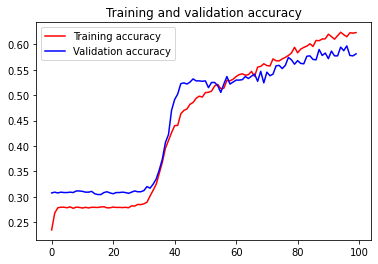

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

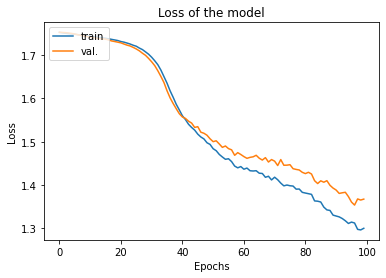

In [ ]:
# comparing training and testing loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Model Save**

In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/62%model1.h5')

# **Model Retraining**

In [ ]:
# Train the model with the new callback

history1=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=100,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
59/89 [==================>...........] - ETA: 1:32 - loss: 1.2806 - accuracy: 0.6263
Epoch 1: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 338s 4s/step - loss: 1.2857 - accuracy: 0.6273 - val_loss: 1.3657 - val_accuracy: 0.5805
Epoch 2/100
89/89 [==============================] - 329s 4s/step - loss: 1.2842 - accuracy: 0.6307 - val_loss: 1.3390 - val_accuracy: 0.5844
Epoch 3/100
89/89 [==============================] - 325s 4s/step - loss: 1.2947 - accuracy: 0.6223 - val_loss: 1.3418 - val_accuracy: 0.5789
Epoch 4/100
89/89 [==============================] - 325s 4s/step - loss: 1.2854 - accuracy: 0.6271 - val_loss: 1.3488 - val_accuracy: 0.5852
Epoch 5/100
89/89 [==============================] - 327s 4s/step - loss: 1.2769 - accuracy: 0.6326 - val_loss: 1.3487 - val_accuracy: 0.5867
Epoch 6/100
89/89 [==============================] - 336s 4s/step - loss: 1.2757 - accuracy: 0.6356 - val_loss: 1.3444 - val_accuracy: 0.5750

# **Retrained Model Save**

In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/69%model2.h5')

# **Retrained Model Evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 8s 380ms/step - loss: 1.1042 - accuracy: 0.6911
Test loss: 1.1041733026504517
Test accuracy: 0.6910755038261414


## **Retrained Model Accuracy & Loss Progress**

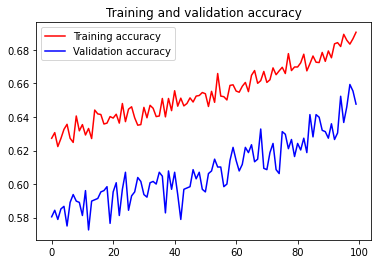

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

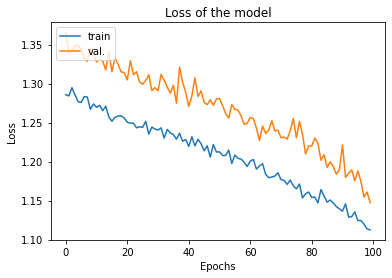

In [ ]:
# comparing training and testing loss 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Continue Model Training and Evaluation  for more epoches.**

In [ ]:
# Train the model with the new callback

history1=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
89/89 [==============================] - 322s 4s/step - loss: 1.1171 - accuracy: 0.6866 - val_loss: 1.1560 - val_accuracy: 0.6516
Epoch 2/30
30/89 [=========>....................] - ETA: 2:48 - loss: 1.0958 - accuracy: 0.6944
Epoch 2: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 320s 4s/step - loss: 1.1192 - accuracy: 0.6834 - val_loss: 1.1682 - val_accuracy: 0.6469
Epoch 3/30
89/89 [==============================] - 320s 4s/step - loss: 1.1130 - accuracy: 0.6905 - val_loss: 1.1592 - val_accuracy: 0.6555
Epoch 4/30
89/89 [==============================] - 319s 4s/step - loss: 1.1157 - accuracy: 0.6900 - val_loss: 1.1682 - val_accuracy: 0.6547
Epoch 5/30
89/89 [==============================] - 319s 4s/step - loss: 1.0944 - accuracy: 0.6985 - val_loss: 1.1558 - val_accuracy: 0.6609
Epoch 6/30
89/89 [==============================] - 319s 4s/step - loss: 1.1018 - accuracy: 0.6979 - val_loss: 1.1306 - val_accuracy: 0.6594
Epoch

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy))

21/21 - 669s - loss: 1.0782 - accuracy: 0.6987 - 669s/epoch - 32s/step
Restored model, accuracy: 69.87%


In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/69.87%model3.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 8s 378ms/step - loss: 1.0782 - accuracy: 0.6987
Test loss: 1.0782233476638794
Test accuracy: 0.6987032890319824


In [ ]:
%matplotlib inline
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

NameError: ignored

In [ ]:
# comparing training and testing loss 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history2=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=50,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
89/89 [==============================] - 3834s 43s/step - loss: 1.0982 - accuracy: 0.7029 - val_loss: 1.1418 - val_accuracy: 0.6594
Epoch 2/50
89/89 [==============================] - 322s 4s/step - loss: 1.0862 - accuracy: 0.7027 - val_loss: 1.1574 - val_accuracy: 0.6555
Epoch 3/50
89/89 [==============================] - 320s 4s/step - loss: 1.0888 - accuracy: 0.7072 - val_loss: 1.1727 - val_accuracy: 0.6516
Epoch 4/50
89/89 [==============================] - 322s 4s/step - loss: 1.0900 - accuracy: 0.7010 - val_loss: 1.1585 - val_accuracy: 0.6625
Epoch 5/50
89/89 [==============================] - 322s 4s/step - loss: 1.0860 - accuracy: 0.7017 - val_loss: 1.1291 - val_accuracy: 0.6695
Epoch 6/50
89/89 [==============================] - 321s 4s/step - loss: 1.0850 - accuracy: 0.7056 - val_loss: 1.1551 - val_accuracy: 0.6609
Epoch 7/50
89/89 [==============================] - 323s 4s/step - loss: 1.0848 - accuracy: 0.7059 - val_loss: 1.1107 - val_accuracy: 0.6781
Epoch 8/50


In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/73%model2.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 8s 377ms/step - loss: 0.9561 - accuracy: 0.7368
Test loss: 0.9560826420783997
Test accuracy: 0.7368420958518982


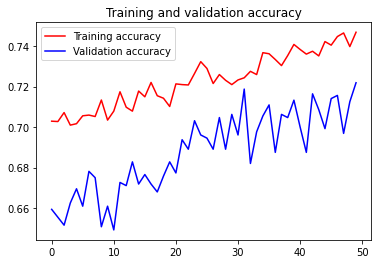

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

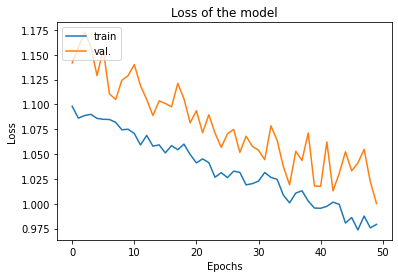

In [ ]:
# comparing training and testing loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history3=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=70,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/70
29/89 [========>.....................] - ETA: 3:03 - loss: 0.9685 - accuracy: 0.7441
Epoch 1: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 335s 4s/step - loss: 0.9755 - accuracy: 0.7450 - val_loss: 0.9943 - val_accuracy: 0.7352
Epoch 2/70
89/89 [==============================] - 332s 4s/step - loss: 0.9837 - accuracy: 0.7442 - val_loss: 0.9892 - val_accuracy: 0.7383
Epoch 3/70
89/89 [==============================] - 331s 4s/step - loss: 0.9795 - accuracy: 0.7433 - val_loss: 1.0173 - val_accuracy: 0.7172
Epoch 4/70
89/89 [==============================] - 331s 4s/step - loss: 0.9522 - accuracy: 0.7519 - val_loss: 0.9997 - val_accuracy: 0.7273
Epoch 5/70
89/89 [==============================] - 331s 4s/step - loss: 0.9662 - accuracy: 0.7493 - val_loss: 1.0102 - val_accuracy: 0.7086
Epoch 6/70
89/89 [==============================] - 331s 4s/step - loss: 0.9630 - accuracy: 0.7512 - val_loss: 1.0049 - val_accuracy: 0.7211
Epoch

In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/80%model5.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 7s 349ms/step - loss: 0.7992 - accuracy: 0.8002
Test loss: 0.7992112040519714
Test accuracy: 0.8001525402069092


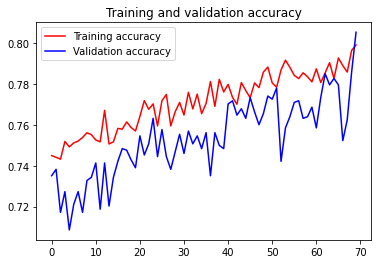

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

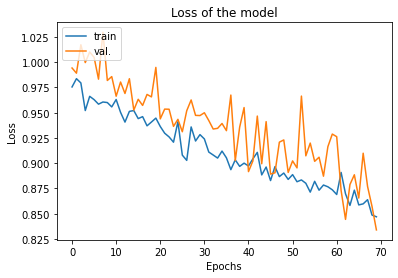

In [ ]:
# comparing training and testing loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history4=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 336s 4s/step - loss: 0.8603 - accuracy: 0.7884 - val_loss: 0.8732 - val_accuracy: 0.7805
Epoch 2/80
89/89 [==============================] - 331s 4s/step - loss: 0.8531 - accuracy: 0.7996 - val_loss: 0.8568 - val_accuracy: 0.7867
Epoch 3/80
21/89 [======>.......................] - ETA: 3:28 - loss: 0.8614 - accuracy: 0.7857
Epoch 3: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 333s 4s/step - loss: 0.8619 - accuracy: 0.7902 - val_loss: 0.8520 - val_accuracy: 0.7703
Epoch 4/80
89/89 [==============================] - 333s 4s/step - loss: 0.8413 - accuracy: 0.7967 - val_loss: 0.8485 - val_accuracy: 0.7961
Epoch 5/80
89/89 [==============================] - 332s 4s/step - loss: 0.8620 - accuracy: 0.7923 - val_loss: 0.9468 - val_accuracy: 0.7680
Epoch 6/80
89/89 [==============================] - 330s 4s/step - loss: 0.8432 - accuracy: 0.7996 - val_loss: 0.9086 - val_accuracy: 0.7695
Epoch

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy))

21/21 - 258s - loss: 0.7411 - accuracy: 0.8223 - 258s/epoch - 12s/step
Restored model, accuracy: 82.23%


In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/82%model6.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 9s 429ms/step - loss: 0.7411 - accuracy: 0.8223
Test loss: 0.7411148548126221
Test accuracy: 0.8222730755805969


In [ ]:
%matplotlib inline
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history5=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 1886s 21s/step - loss: 0.7792 - accuracy: 0.8240 - val_loss: 0.7706 - val_accuracy: 0.8273
Epoch 2/80
89/89 [==============================] - 339s 4s/step - loss: 0.7585 - accuracy: 0.8297 - val_loss: 0.7676 - val_accuracy: 0.8328
Epoch 3/80
89/89 [==============================] - 338s 4s/step - loss: 0.7751 - accuracy: 0.8261 - val_loss: 0.7721 - val_accuracy: 0.8219
Epoch 4/80
89/89 [==============================] - 340s 4s/step - loss: 0.7511 - accuracy: 0.8376 - val_loss: 0.7631 - val_accuracy: 0.8266
Epoch 5/80
89/89 [==============================] - 340s 4s/step - loss: 0.7643 - accuracy: 0.8252 - val_loss: 0.7693 - val_accuracy: 0.8047
Epoch 6/80
89/89 [==============================] - 341s 4s/step - loss: 0.7707 - accuracy: 0.8251 - val_loss: 0.8226 - val_accuracy: 0.8023
Epoch 7/80
89/89 [==============================] - 339s 4s/step - loss: 0.7589 - accuracy: 0.8337 - val_loss: 0.7887 - val_accuracy: 0.8062
Epoch 8/80


In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/82%+model5.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
%matplotlib inline
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy))

21/21 - 8s - loss: 0.6640 - accuracy: 0.8551 - 8s/epoch - 396ms/step
Restored model, accuracy: 85.51%


In [ ]:
model.save('/content/drive/MyDrive/Final Model(with augmentation)/85%model7.h5')

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 323s 16s/step - loss: 0.6640 - accuracy: 0.8551
Test loss: 0.6640017032623291
Test accuracy: 0.8550724387168884


In [ ]:
# Train the model with the new callback

history6=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 1751s 20s/step - loss: 0.7306 - accuracy: 0.8424 - val_loss: 0.7957 - val_accuracy: 0.8250
Epoch 2/80
89/89 [==============================] - 364s 4s/step - loss: 0.7230 - accuracy: 0.8477 - val_loss: 0.7488 - val_accuracy: 0.8383
Epoch 3/80
89/89 [==============================] - 366s 4s/step - loss: 0.7322 - accuracy: 0.8449 - val_loss: 0.7610 - val_accuracy: 0.8313
Epoch 4/80
89/89 [==============================] - 370s 4s/step - loss: 0.7137 - accuracy: 0.8468 - val_loss: 0.7423 - val_accuracy: 0.8297
Epoch 5/80
89/89 [==============================] - 370s 4s/step - loss: 0.7280 - accuracy: 0.8399 - val_loss: 0.7155 - val_accuracy: 0.8414
Epoch 6/80
89/89 [==============================] - 369s 4s/step - loss: 0.7389 - accuracy: 0.8371 - val_loss: 0.7426 - val_accuracy: 0.8250
Epoch 7/80
89/89 [==============================] - 368s 4s/step - loss: 0.7259 - accuracy: 0.8438 - val_loss: 0.7663 - val_accuracy: 0.8188
Epoch 8/80


In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt1.h5')

21/21 [==============================] - 9s 413ms/step - loss: 0.6017 - accuracy: 0.8940
Test loss: 0.6017327904701233
Test accuracy: 0.8939740657806396


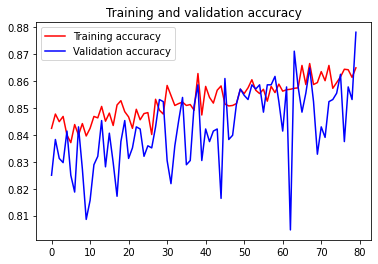

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

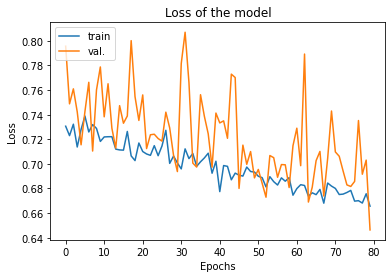

In [ ]:
# comparing training and testing loss 
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history7=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 376s 4s/step - loss: 0.6648 - accuracy: 0.8658 - val_loss: 0.6696 - val_accuracy: 0.8531
Epoch 2/80
89/89 [==============================] - 364s 4s/step - loss: 0.6618 - accuracy: 0.8638 - val_loss: 0.6886 - val_accuracy: 0.8586
Epoch 3/80
89/89 [==============================] - 356s 4s/step - loss: 0.6654 - accuracy: 0.8684 - val_loss: 0.7080 - val_accuracy: 0.8336
Epoch 4/80
89/89 [==============================] - 350s 4s/step - loss: 0.6661 - accuracy: 0.8646 - val_loss: 0.6601 - val_accuracy: 0.8742
Epoch 5/80
89/89 [==============================] - 353s 4s/step - loss: 0.6545 - accuracy: 0.8686 - val_loss: 0.6817 - val_accuracy: 0.8586
Epoch 6/80
89/89 [==============================] - 350s 4s/step - loss: 0.6587 - accuracy: 0.8621 - val_loss: 0.6801 - val_accuracy: 0.8562
Epoch 7/80
25/89 [=======>......................] - ETA: 3:24 - loss: 0.6391 - accuracy: 0.8662
Epoch 7: saving model to /content/drive/MyDrive/Project/wm

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt9.h5')

21/21 [==============================] - 8s 392ms/step - loss: 0.5609 - accuracy: 0.9062
Test loss: 0.560907244682312
Test accuracy: 0.9061784744262695


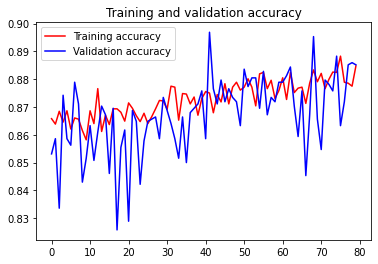

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

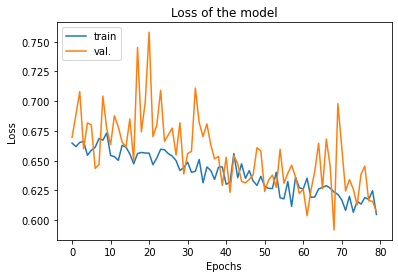

In [ ]:
# comparing training and testing loss 
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history8=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
89/89 [==============================] - 353s 4s/step - loss: 0.6041 - accuracy: 0.8881 - val_loss: 0.6354 - val_accuracy: 0.8734
Epoch 2/30
89/89 [==============================] - 348s 4s/step - loss: 0.6101 - accuracy: 0.8830 - val_loss: 0.6625 - val_accuracy: 0.8531
Epoch 3/30
89/89 [==============================] - 348s 4s/step - loss: 0.6031 - accuracy: 0.8828 - val_loss: 0.5775 - val_accuracy: 0.8938
Epoch 4/30
89/89 [==============================] - 349s 4s/step - loss: 0.6106 - accuracy: 0.8862 - val_loss: 0.6260 - val_accuracy: 0.8844
Epoch 5/30
89/89 [==============================] - 350s 4s/step - loss: 0.6116 - accuracy: 0.8803 - val_loss: 0.6765 - val_accuracy: 0.8633
Epoch 6/30
34/89 [==========>...................] - ETA: 2:53 - loss: 0.6392 - accuracy: 0.8708
Epoch 6: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 350s 4s/step - loss: 0.6154 - accuracy: 0.8792 - val_loss: 0.6292 - val_accuracy: 0.8883
Epoch

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 8s 395ms/step - loss: 0.5458 - accuracy: 0.9161
Test loss: 0.5458002686500549
Test accuracy: 0.9160946011543274


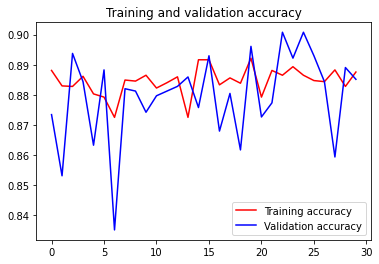

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

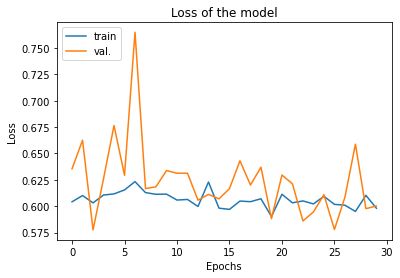

In [ ]:
# comparing training and testing loss 
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history9=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
89/89 [==============================] - 362s 4s/step - loss: 0.5997 - accuracy: 0.8876 - val_loss: 0.6411 - val_accuracy: 0.8672
Epoch 2/30
89/89 [==============================] - 359s 4s/step - loss: 0.5987 - accuracy: 0.8890 - val_loss: 0.6194 - val_accuracy: 0.8828
Epoch 3/30
89/89 [==============================] - 353s 4s/step - loss: 0.5903 - accuracy: 0.8865 - val_loss: 0.5972 - val_accuracy: 0.8938
Epoch 4/30
89/89 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.8900

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

In [ ]:
%matplotlib inline
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
model_nw=load_model('/content/drive/MyDrive/Final Model(with augmentation)/91.61bt1.h5')

In [ ]:
score = model_nw.evaluate(test_generator, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)

21/21 - 8s - loss: 0.5458 - accuracy: 0.9161 - 8s/epoch - 405ms/step
Test loss: 0.5458002686500549
Test accuracy: 0.9160946011543274


In [ ]:
# Train the model with the new callback

history10=model_nw.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
89/89 [==============================] - 348s 4s/step - loss: 0.5907 - accuracy: 0.8890 - val_loss: 0.6314 - val_accuracy: 0.8813
Epoch 2/30
75/89 [========================>.....] - ETA: 43s - loss: 0.5874 - accuracy: 0.8906
Epoch 2: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 341s 4s/step - loss: 0.5854 - accuracy: 0.8900 - val_loss: 0.6340 - val_accuracy: 0.8687
Epoch 3/30
89/89 [==============================] - 342s 4s/step - loss: 0.5939 - accuracy: 0.8874 - val_loss: 0.6298 - val_accuracy: 0.8773
Epoch 4/30
89/89 [==============================] - 341s 4s/step - loss: 0.5934 - accuracy: 0.8895 - val_loss: 0.5937 - val_accuracy: 0.8883
Epoch 5/30
89/89 [==============================] - 342s 4s/step - loss: 0.5880 - accuracy: 0.8915 - val_loss: 0.6064 - val_accuracy: 0.8867
Epoch 6/30
89/89 [==============================] - 341s 4s/step - loss: 0.5882 - accuracy: 0.8890 - val_loss: 0.6075 - val_accuracy: 0.8891
Epoch 

In [ ]:
score = model_nw.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 8s 388ms/step - loss: 0.5216 - accuracy: 0.9260
Test loss: 0.5215733647346497
Test accuracy: 0.9260106682777405


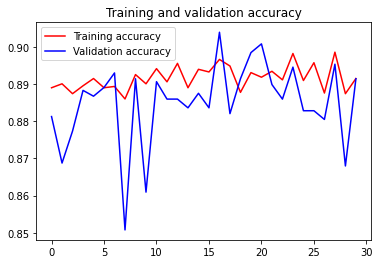

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

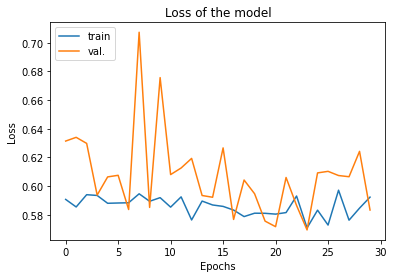

In [ ]:
# comparing training and testing loss 
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history11=model_nw.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
54/89 [=================>............] - ETA: 1:52 - loss: 0.5711 - accuracy: 0.8932
Epoch 1: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 348s 4s/step - loss: 0.5746 - accuracy: 0.8918 - val_loss: 0.6006 - val_accuracy: 0.8773
Epoch 2/80
89/89 [==============================] - 341s 4s/step - loss: 0.5794 - accuracy: 0.8924 - val_loss: 0.6005 - val_accuracy: 0.8758
Epoch 3/80
89/89 [==============================] - 331s 4s/step - loss: 0.5885 - accuracy: 0.8877 - val_loss: 0.6127 - val_accuracy: 0.8891
Epoch 4/80
89/89 [==============================] - 329s 4s/step - loss: 0.5678 - accuracy: 0.8961 - val_loss: 0.8360 - val_accuracy: 0.8102
Epoch 5/80
89/89 [==============================] - 335s 4s/step - loss: 0.5784 - accuracy: 0.8924 - val_loss: 0.5839 - val_accuracy: 0.8906
Epoch 6/80
89/89 [==============================] - 328s 4s/step - loss: 0.5651 - accuracy: 0.8943 - val_loss: 0.5979 - val_accuracy: 0.8914
Epoch

In [ ]:
score = model_nw.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 8s 386ms/step - loss: 0.4978 - accuracy: 0.9291
Test loss: 0.49780383706092834
Test accuracy: 0.929061770439148


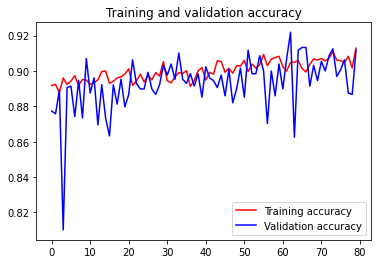

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history11.history['accuracy']
val_acc = history11.history['val_accuracy']
loss = history11.history['loss']
val_loss = history11.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

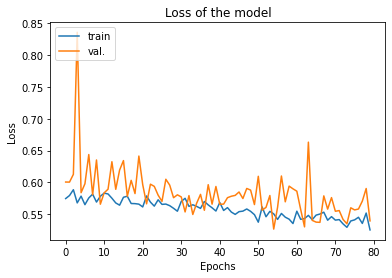

In [ ]:
# comparing training and testing loss 
plt.plot(history11.history['loss'])
plt.plot(history11.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history12=model_nw.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=90,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/90
89/89 [==============================] - 358s 4s/step - loss: 0.5383 - accuracy: 0.9040 - val_loss: 0.5631 - val_accuracy: 0.8938
Epoch 2/90
89/89 [==============================] - 347s 4s/step - loss: 0.5386 - accuracy: 0.9067 - val_loss: 0.5437 - val_accuracy: 0.9070
Epoch 3/90
89/89 [==============================] - 352s 4s/step - loss: 0.5555 - accuracy: 0.8978 - val_loss: 0.6548 - val_accuracy: 0.8555
Epoch 4/90
89/89 [==============================] - 354s 4s/step - loss: 0.5470 - accuracy: 0.9032 - val_loss: 0.5316 - val_accuracy: 0.9062
Epoch 5/90
89/89 [==============================] - 354s 4s/step - loss: 0.5333 - accuracy: 0.9081 - val_loss: 0.5486 - val_accuracy: 0.9016
Epoch 6/90
89/89 [==============================] - 353s 4s/step - loss: 0.5390 - accuracy: 0.9069 - val_loss: 0.5624 - val_accuracy: 0.9062
Epoch 7/90
80/89 [=========================>....] - ETA: 29s - loss: 0.5258 - accuracy: 0.9096
Epoch 7: saving model to /content/drive/MyDrive/Project/wm_

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 206s 10s/step - loss: 0.4938 - accuracy: 0.9298
Test loss: 0.4937672019004822
Test accuracy: 0.9298245906829834


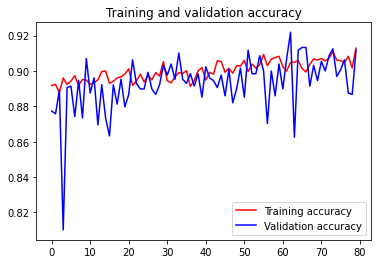

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history12.history['accuracy']
val_acc = history12.history['val_accuracy']
loss = history12.history['loss']
val_loss = history12.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

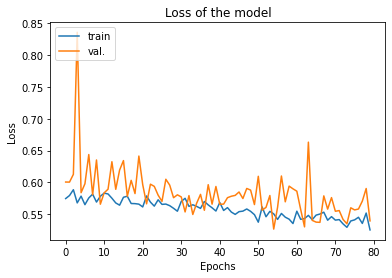

In [ ]:
# comparing training and testing loss 
plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history13=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=90,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/90
89/89 [==============================] - 1610s 18s/step - loss: 0.5352 - accuracy: 0.9079 - val_loss: 0.5828 - val_accuracy: 0.8914
Epoch 2/90
89/89 [==============================] - 345s 4s/step - loss: 0.5210 - accuracy: 0.9115 - val_loss: 0.5363 - val_accuracy: 0.9117
Epoch 3/90
89/89 [==============================] - 342s 4s/step - loss: 0.5353 - accuracy: 0.9065 - val_loss: 0.5522 - val_accuracy: 0.8938
Epoch 4/90
89/89 [==============================] - 343s 4s/step - loss: 0.5390 - accuracy: 0.9026 - val_loss: 0.5530 - val_accuracy: 0.9047
Epoch 5/90
89/89 [==============================] - 346s 4s/step - loss: 0.5329 - accuracy: 0.9079 - val_loss: 0.5351 - val_accuracy: 0.9023
Epoch 6/90
89/89 [==============================] - 344s 4s/step - loss: 0.5246 - accuracy: 0.9063 - val_loss: 0.5381 - val_accuracy: 0.9133
Epoch 7/90
89/89 [==============================] - 346s 4s/step - loss: 0.5289 - accuracy: 0.9044 - val_loss: 0.5256 - val_accuracy: 0.9125
Epoch 8/90


In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 8s 392ms/step - loss: 0.4556 - accuracy: 0.9436
Test loss: 0.45556044578552246
Test accuracy: 0.9435545206069946


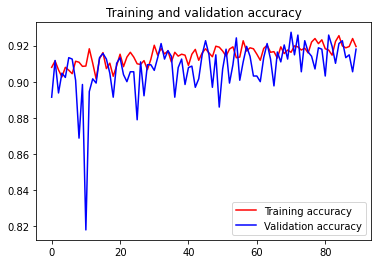

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history13.history['accuracy']
val_acc = history13.history['val_accuracy']
loss = history13.history['loss']
val_loss = history13.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

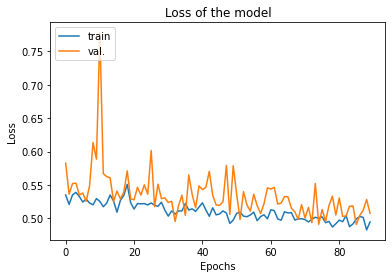

In [ ]:
# comparing training and testing loss 
plt.plot(history13.history['loss'])
plt.plot(history13.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history14=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=90,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/90
89/89 [==============================] - 354s 4s/step - loss: 0.4927 - accuracy: 0.9193 - val_loss: 0.5119 - val_accuracy: 0.9062
Epoch 2/90
89/89 [==============================] - 343s 4s/step - loss: 0.4947 - accuracy: 0.9187 - val_loss: 0.4884 - val_accuracy: 0.9258
Epoch 3/90
89/89 [==============================] - 337s 4s/step - loss: 0.4851 - accuracy: 0.9209 - val_loss: 0.5058 - val_accuracy: 0.9164
Epoch 4/90
42/89 [=============>................] - ETA: 2:24 - loss: 0.4818 - accuracy: 0.9256
Epoch 4: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 334s 4s/step - loss: 0.4907 - accuracy: 0.9228 - val_loss: 0.5096 - val_accuracy: 0.9164
Epoch 5/90
89/89 [==============================] - 333s 4s/step - loss: 0.4842 - accuracy: 0.9212 - val_loss: 0.4741 - val_accuracy: 0.9273
Epoch 6/90
89/89 [==============================] - 335s 4s/step - loss: 0.4841 - accuracy: 0.9249 - val_loss: 0.5103 - val_accuracy: 0.9164
Epoch

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

In [ ]:
%matplotlib inline
acc = history14.history['accuracy']
val_acc = history14.history['val_accuracy']
loss = history14.history['loss']
val_loss = history14.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history14.history['loss'])
plt.plot(history14.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
a1

21/21 [==============================] - 881s 44s/step - loss: 0.4403 - accuracy: 0.9497
Test loss: 0.44027194380760193
Test accuracy: 0.9496567249298096


94.97

In [ ]:
# Train the model with the new callback

history15=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=90,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/90
89/89 [==============================] - 4075s 46s/step - loss: 0.4847 - accuracy: 0.9221 - val_loss: 0.4830 - val_accuracy: 0.9297
Epoch 2/90
89/89 [==============================] - 325s 4s/step - loss: 0.4770 - accuracy: 0.9248 - val_loss: 0.4934 - val_accuracy: 0.9227
Epoch 3/90
89/89 [==============================] - 324s 4s/step - loss: 0.4827 - accuracy: 0.9223 - val_loss: 0.5256 - val_accuracy: 0.9078
Epoch 4/90
89/89 [==============================] - 324s 4s/step - loss: 0.4721 - accuracy: 0.9251 - val_loss: 0.5033 - val_accuracy: 0.9211
Epoch 5/90
89/89 [==============================] - 321s 4s/step - loss: 0.4809 - accuracy: 0.9253 - val_loss: 0.5411 - val_accuracy: 0.9094
Epoch 6/90
89/89 [==============================] - 321s 4s/step - loss: 0.4845 - accuracy: 0.9221 - val_loss: 0.4866 - val_accuracy: 0.9305
Epoch 7/90
89/89 [==============================] - 320s 4s/step - loss: 0.4715 - accuracy: 0.9302 - val_loss: 0.4872 - val_accuracy: 0.9289
Epoch 8/90


In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt12.h5')

21/21 [==============================] - 7s 333ms/step - loss: 0.4568 - accuracy: 0.9336
Test loss: 0.45684781670570374
Test accuracy: 0.9336384534835815


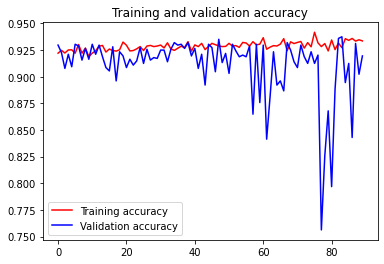

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']
loss = history15.history['loss']
val_loss = history15.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

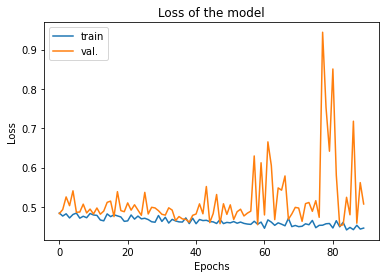

In [ ]:
# comparing training and testing loss 
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history16=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=90,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/90
89/89 [==============================] - 321s 4s/step - loss: 0.4589 - accuracy: 0.9262 - val_loss: 0.4604 - val_accuracy: 0.9320
Epoch 2/90
89/89 [==============================] - 316s 4s/step - loss: 0.4472 - accuracy: 0.9313 - val_loss: 0.4592 - val_accuracy: 0.9367
Epoch 3/90
89/89 [==============================] - 315s 4s/step - loss: 0.4459 - accuracy: 0.9354 - val_loss: 0.4533 - val_accuracy: 0.9297
Epoch 4/90
42/89 [=============>................] - ETA: 2:14 - loss: 0.4455 - accuracy: 0.9364
Epoch 4: saving model to /content/drive/MyDrive/Project/wm_save
89/89 [==============================] - 318s 4s/step - loss: 0.4443 - accuracy: 0.9354 - val_loss: 0.4458 - val_accuracy: 0.9352
Epoch 5/90
89/89 [==============================] - 315s 4s/step - loss: 0.4581 - accuracy: 0.9276 - val_loss: 0.4579 - val_accuracy: 0.9328
Epoch 6/90
89/89 [==============================] - 316s 4s/step - loss: 0.4482 - accuracy: 0.9320 - val_loss: 0.5030 - val_accuracy: 0.9070
Epoch

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt12.h5')

In [ ]:
%matplotlib inline
acc = history16.history['accuracy']
val_acc = history16.history['val_accuracy']
loss = history16.history['loss']
val_loss = history16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history16.history['loss'])
plt.plot(history16.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Final Model(with augmentation)/wm_save"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 275s 13s/step - loss: 0.4235 - accuracy: 0.9474
Test loss: 0.42349469661712646
Test accuracy: 0.9473684430122375


In [ ]:
# Train the model with the new callback

history17=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 1842s 21s/step - loss: 0.4376 - accuracy: 0.9352 - val_loss: 0.4557 - val_accuracy: 0.9281
Epoch 2/80
89/89 [==============================] - 348s 4s/step - loss: 0.4354 - accuracy: 0.9364 - val_loss: 0.4671 - val_accuracy: 0.9297
Epoch 3/80
89/89 [==============================] - 348s 4s/step - loss: 0.4409 - accuracy: 0.9331 - val_loss: 0.6144 - val_accuracy: 0.8617
Epoch 4/80
89/89 [==============================] - 347s 4s/step - loss: 0.4445 - accuracy: 0.9317 - val_loss: 0.4456 - val_accuracy: 0.9352
Epoch 5/80
89/89 [==============================] - 345s 4s/step - loss: 0.4275 - accuracy: 0.9380 - val_loss: 0.6296 - val_accuracy: 0.8773
Epoch 6/80
89/89 [==============================] - 347s 4s/step - loss: 0.4362 - accuracy: 0.9375 - val_loss: 0.4656 - val_accuracy: 0.9289
Epoch 7/80
89/89 [==============================] - 346s 4s/step - loss: 0.4402 - accuracy: 0.9340 - val_loss: 0.5909 - val_accuracy: 0.8813
Epoch 8/80


In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt12.h5')

21/21 [==============================] - 8s 380ms/step - loss: 0.3890 - accuracy: 0.9565
Test loss: 0.3890407979488373
Test accuracy: 0.95652174949646


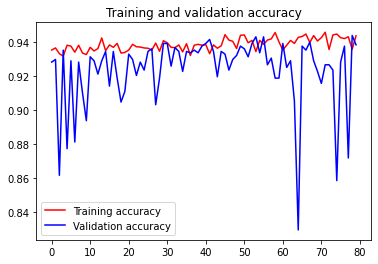

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history17.history['accuracy']
val_acc = history17.history['val_accuracy']
loss = history17.history['loss']
val_loss = history17.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

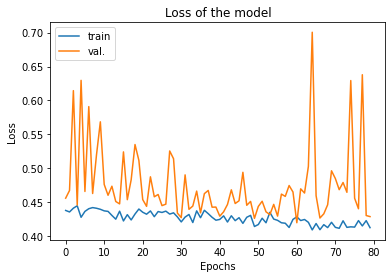

In [ ]:
# comparing training and testing loss 
plt.plot(history17.history['loss'])
plt.plot(history17.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
# Train the model with the new callback

history18=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=80,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/80
89/89 [==============================] - 344s 4s/step - loss: 0.4110 - accuracy: 0.9433 - val_loss: 0.4872 - val_accuracy: 0.9156
Epoch 2/80
89/89 [==============================] - 339s 4s/step - loss: 0.4194 - accuracy: 0.9394 - val_loss: 0.6410 - val_accuracy: 0.8477
Epoch 3/80
89/89 [==============================] - 340s 4s/step - loss: 0.4183 - accuracy: 0.9394 - val_loss: 0.5068 - val_accuracy: 0.9000
Epoch 4/80
89/89 [==============================] - 341s 4s/step - loss: 0.4134 - accuracy: 0.9412 - val_loss: 1.1977 - val_accuracy: 0.7148
Epoch 5/80
89/89 [==============================] - 340s 4s/step - loss: 0.4087 - accuracy: 0.9419 - val_loss: 0.4734 - val_accuracy: 0.9281
Epoch 6/80
89/89 [==============================] - 341s 4s/step - loss: 0.4165 - accuracy: 0.9380 - val_loss: 0.4421 - val_accuracy: 0.9359
Epoch 7/80
25/89 [=======>......................] - ETA: 3:14 - loss: 0.4189 - accuracy: 0.9330
Epoch 7: saving model to /content/drive/MyDrive/Final Mode

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt12.h5')

In [ ]:
%matplotlib inline
acc = history18.history['accuracy']
val_acc = history18.history['val_accuracy']
loss = history18.history['loss']
val_loss = history18.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history18.history['loss'])
plt.plot(history18.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
a1
#Saving the weight of the model
# model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt10.h5')

21/21 [==============================] - 446s 22s/step - loss: 0.3966 - accuracy: 0.9565
Test loss: 0.3966376483440399
Test accuracy: 0.95652174949646


In [ ]:
# Train the model with the new callback

history19=model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=50,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size,
  verbose=1,
  callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
89/89 [==============================] - 2291s 26s/step - loss: 0.4062 - accuracy: 0.9446 - val_loss: 0.4548 - val_accuracy: 0.9273
Epoch 2/50
89/89 [==============================] - 343s 4s/step - loss: 0.4239 - accuracy: 0.9380 - val_loss: 0.6520 - val_accuracy: 0.8578
Epoch 3/50
89/89 [==============================] - 345s 4s/step - loss: 0.3991 - accuracy: 0.9446 - val_loss: 0.4917 - val_accuracy: 0.9055
Epoch 4/50
89/89 [==============================] - 343s 4s/step - loss: 0.4111 - accuracy: 0.9441 - val_loss: 0.4666 - val_accuracy: 0.9250
Epoch 5/50
89/89 [==============================] - 343s 4s/step - loss: 0.4071 - accuracy: 0.9441 - val_loss: 0.4348 - val_accuracy: 0.9406
Epoch 6/50
89/89 [==============================] - 342s 4s/step - loss: 0.4069 - accuracy: 0.9423 - val_loss: 0.4169 - val_accuracy: 0.9359
Epoch 7/50
89/89 [==============================] - 341s 4s/step - loss: 0.4084 - accuracy: 0.9439 - val_loss: 0.5243 - val_accuracy: 0.9016
Epoch 8/50


In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Final Model(with augmentation)/'+str(a1)+'bt12.h5')

21/21 [==============================] - 8s 391ms/step - loss: 0.3890 - accuracy: 0.9558
Test loss: 0.3889906704425812
Test accuracy: 0.9557589888572693


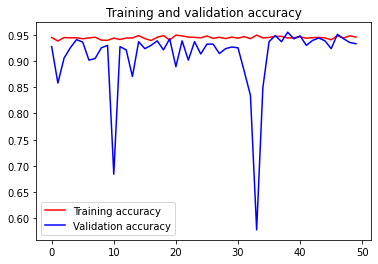

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history19.history['accuracy']
val_acc = history19.history['val_accuracy']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

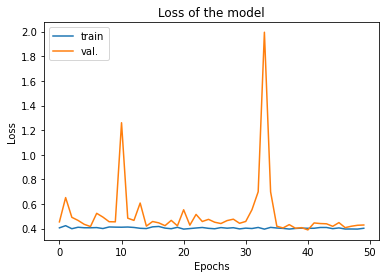

In [ ]:
# comparing training and testing loss 
plt.plot(history19.history['loss'])
plt.plot(history19.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

## **Load the High Accuracy Model for Testing.**

In [ ]:
model_nw=load_model('/content/drive/MyDrive/Final Model(with augmentation)/94.36bt10.h5')

# **Model Evaluation**

# **Accuracy**

In [ ]:
score = model_nw.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 283s 14s/step - loss: 0.4556 - accuracy: 0.9436
Test loss: 0.45556044578552246
Test accuracy: 0.9435545206069946


## **Confusion_Matrix**

In [ ]:
pred_test=model_nw.predict(test_generator)

In [ ]:
classes=list(train_generator.class_indices.keys())

In [ ]:
test_labels=test_generator.classes


predict_labels_Test
Numbre of glioma : 286
Numbre of meningioma : 316
Numbre of notumor : 411
Numbre of pituitary : 298

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       286
           1       0.92      0.90      0.91       316
           2       0.99      0.98      0.98       411
           3       0.96      0.96      0.96       298

   micro avg       0.94      0.94      0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311
 samples avg       0.94      0.94      0.94      1311

Confusion Matrix


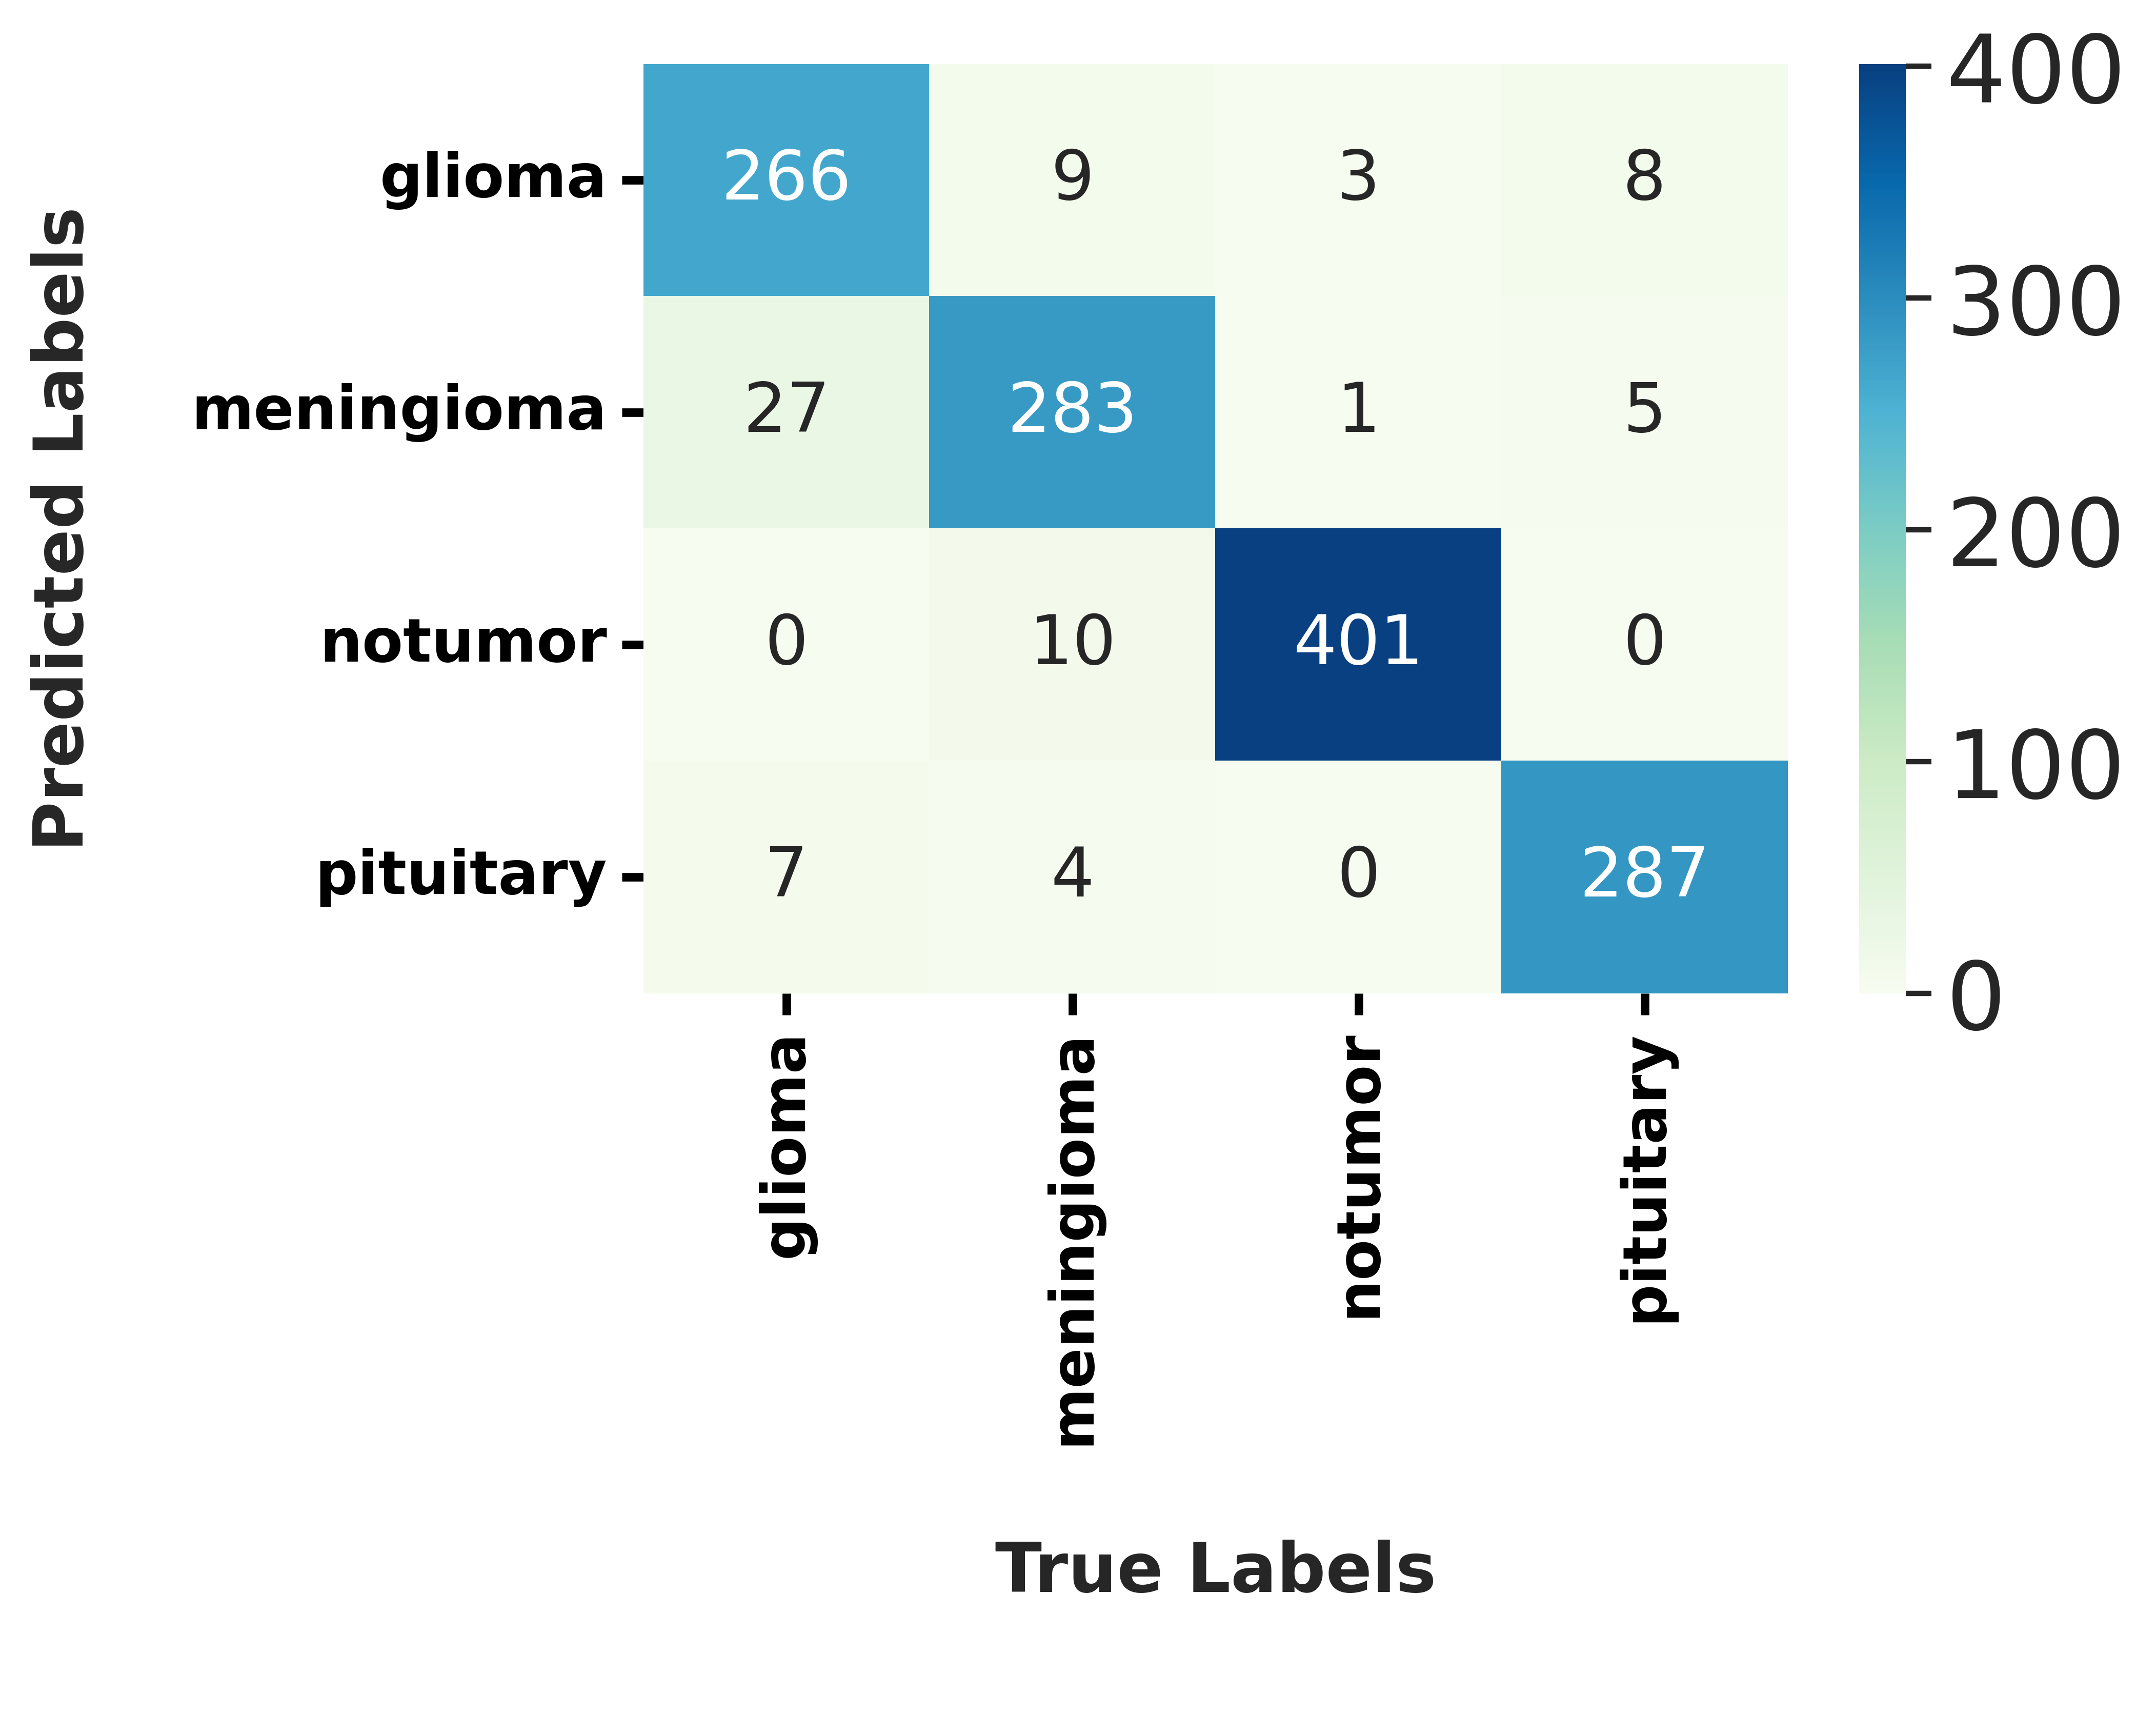

In [ ]:
predict_labels_Test = pred_test
predict_labels=np.argmax(predict_labels_Test, axis=1)
# print(predict_labels)

predict_labels_TestV2_ctg = np_utils.to_categorical(predict_labels, num_classes)
labels_Test_ctg = np_utils.to_categorical(test_labels, num_classes)
predict_labels_Ar = np.asarray(predict_labels)
print("\npredict_labels_Test")
print(f'Numbre of {classes[0]} : {(predict_labels_Ar == 0).sum()}')
print(f'Numbre of {classes[1]} : {(predict_labels_Ar == 1).sum()}')
print(f'Numbre of {classes[2]} : {(predict_labels_Ar == 2).sum()}')
print(f'Numbre of {classes[3]} : {(predict_labels_Ar == 3).sum()}')

print("\n"+classification_report(predict_labels_TestV2_ctg, labels_Test_ctg))

cm = confusion_matrix(predict_labels, test_labels) 
#cm1=np.array([[126, 1, 3], [0,193,9],[0,7,190]])
print('Confusion Matrix')
plt.figure()
ax= plt.subplot()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.tick_params(direction='out', length=5, width=2, colors='black',
               grid_color='black', grid_alpha=0.5)
sns.set(font_scale=2)
sns.heatmap(cm, annot= True, fmt='', cmap='GnBu', cbar=True, annot_kws={"size": 16})
labels=classes
plt.rcParams.update(andy_theme)
ax.set_xlabel("\nTrue Labels\n" ,fontweight="bold")
ax.set_ylabel("Predicted Labels\n" ,fontweight="bold")
#ax.set_title('Confusion Matrix of VGG 16 Model',fontweight="bold"); 
ax.xaxis.set_ticklabels(labels,fontweight="bold", rotation = 90,); 
ax.yaxis.set_ticklabels(labels,fontweight="bold", rotation = 0,);

plt.show()

In [ ]:
test_classes=to_categorical(test_labels)

In [ ]:
Accuracy=accuracy_score(test_labels,predict_labels)
Accuracy

0.9435545385202135

# **ROC_AUC Curve**

In [ ]:
AUC=roc_auc_score(test_classes,pred_test)
AUC

0.991928414573291

ROC AUC score: 0.9604696665941715


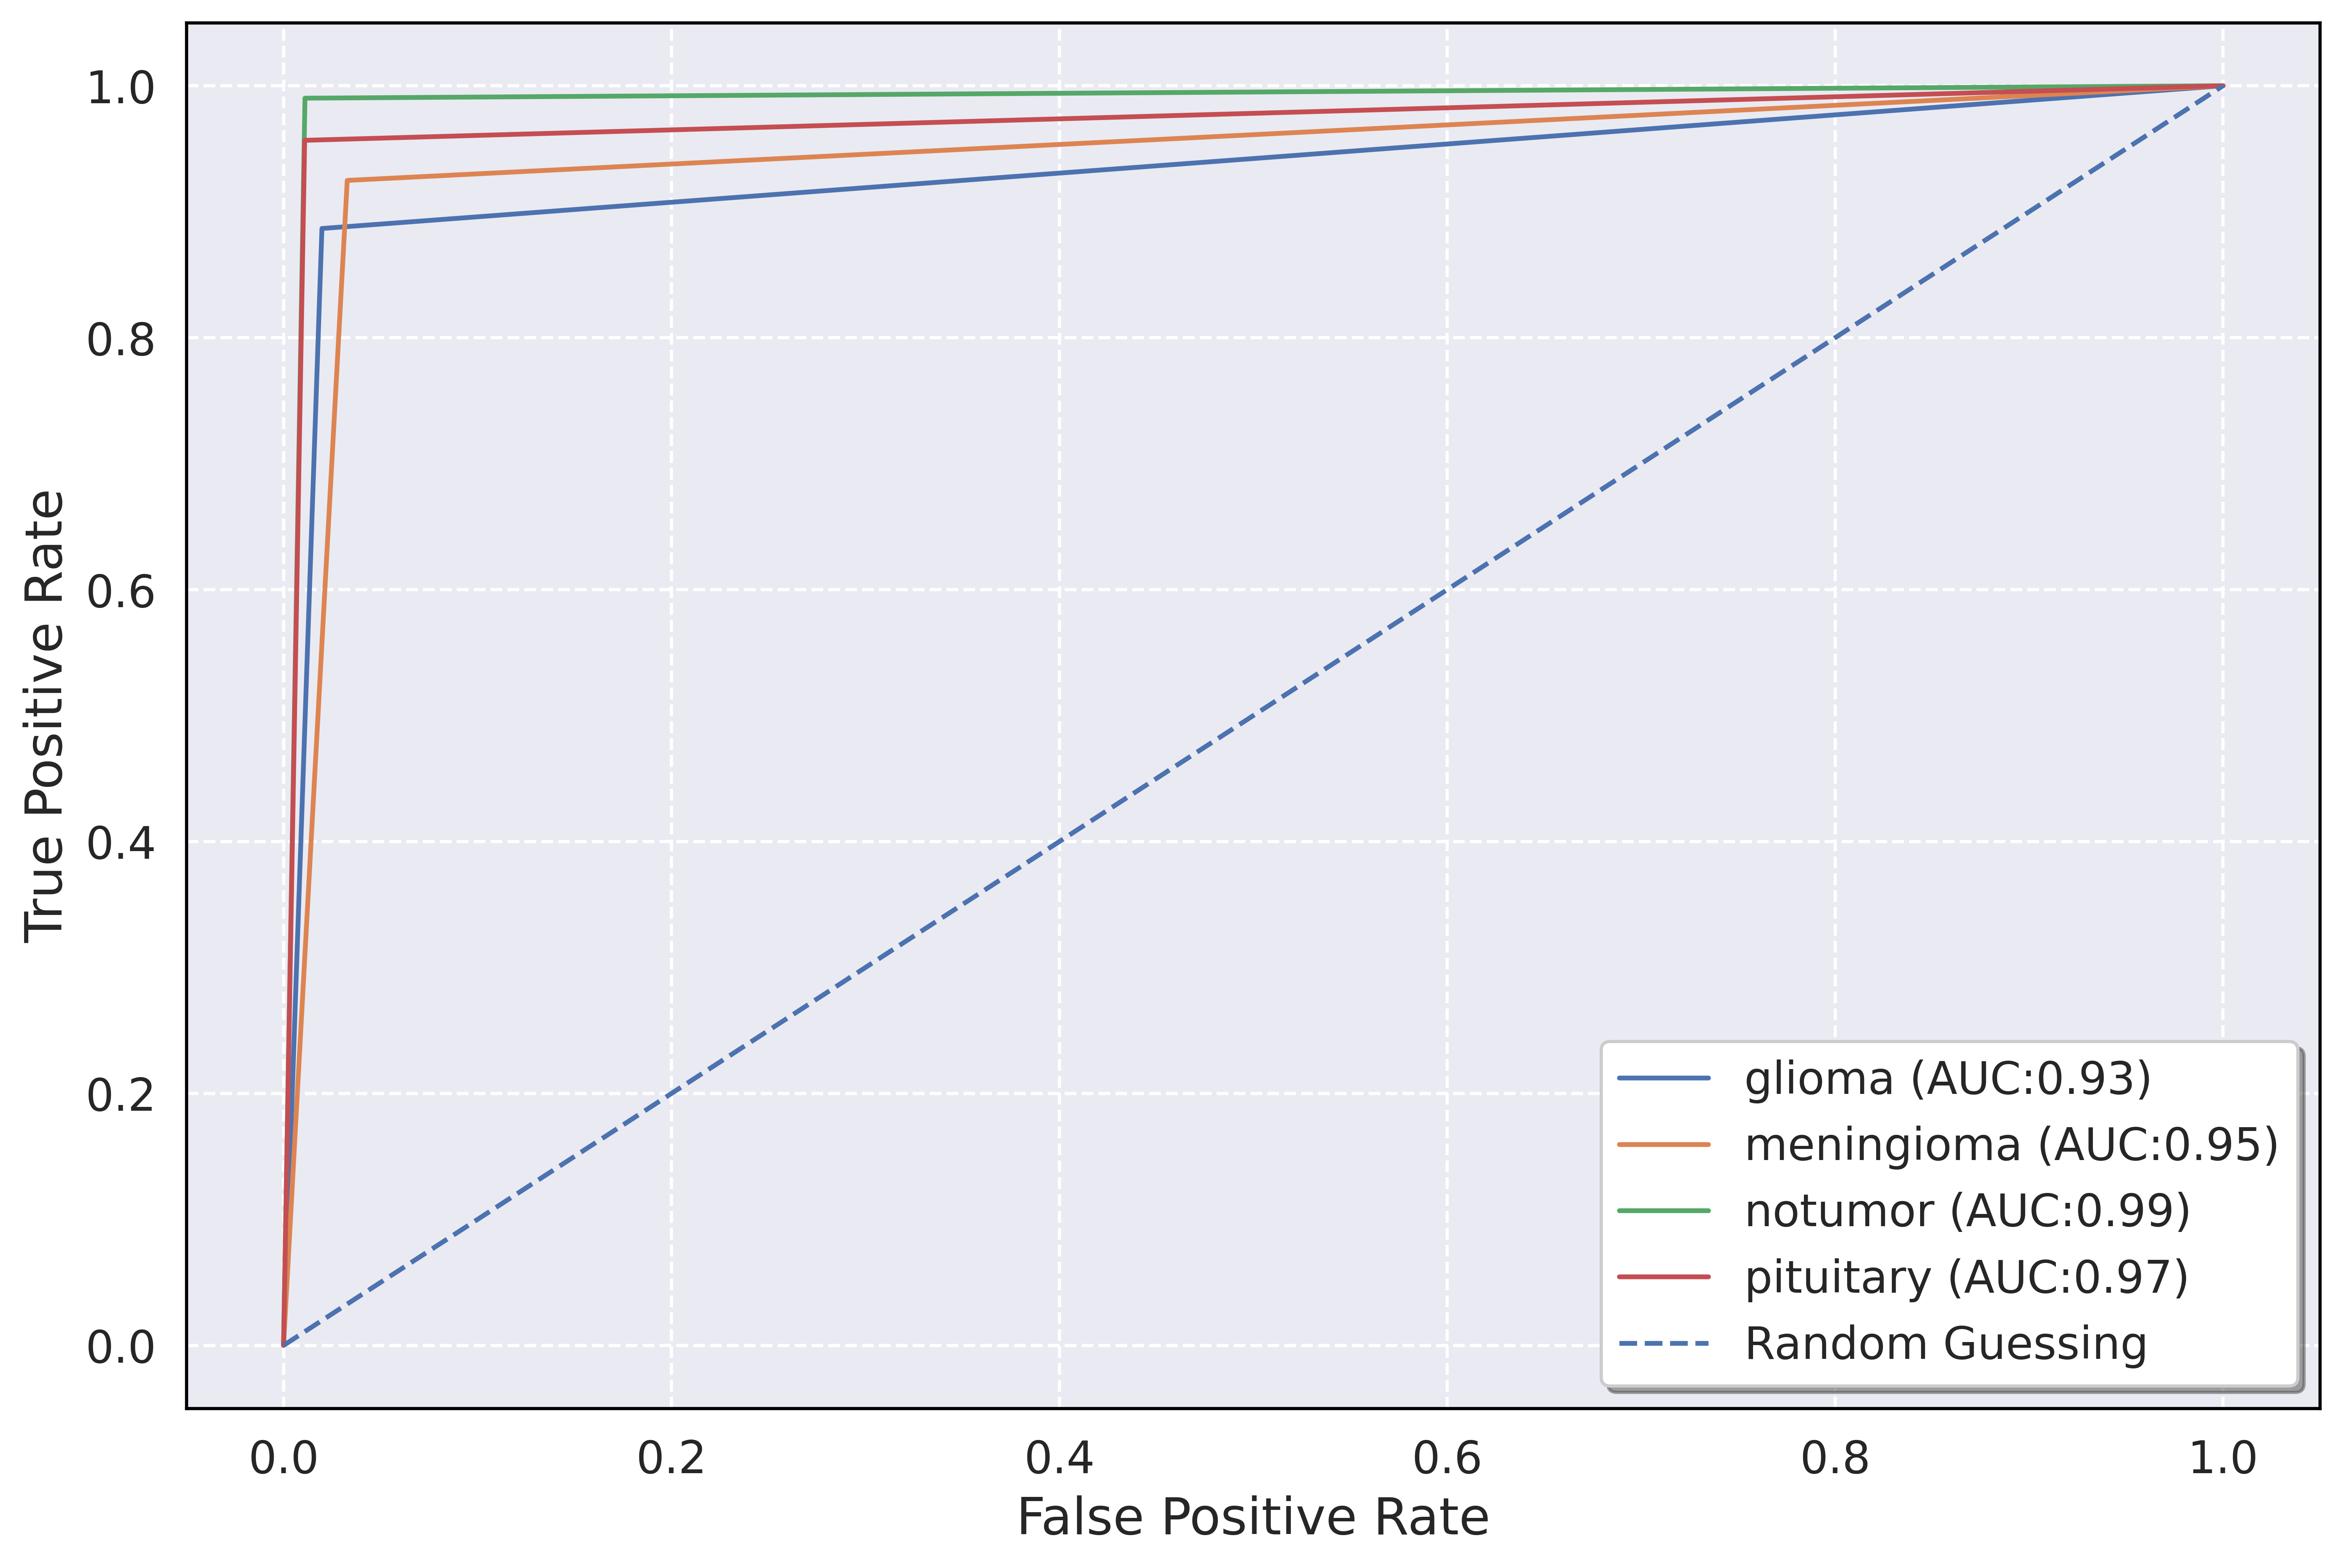

In [ ]:
target= list(test_generator.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', linestyle='--',label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_generator.classes,predict_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


# **Model Testing**

In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='sparse',
  shuffle=True
  )

Found 1311 images belonging to 4 classes.


In [ ]:
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
images, labels = next(test_generator)
plt.figure(figsize=(20, 20))
for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        # plt.grid()
        predictions = model_nw.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[int(labels[i])]==class_names[np.argmax(score)]):
            plt.title("Actual: "+ class_names[int(labels[i])],fontsize=16)
            plt.xlabel("Predicted: "+ class_names[np.argmax(score)],fontsize=16,fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+ class_names[int(labels[i])],fontsize=16)
            plt.xlabel("Predicted: "+ class_names[np.argmax(score)],fontsize=16, fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])